In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

## Load Files Function

In [2]:
def filelist(root):
    '''
    Return a fully-qualified list of filenames under root directory; 
    sort names alphabetically.
    '''
    allfiles = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            allfiles.append(os.path.join(path, name))
    return sorted(allfiles)

## Process Files (Helper Functions)

In [4]:
def longest_true_seq(bool_curve):
    '''
    Given an array of booleans,
    return indices of longest streak
    of Trues
    '''
    longest_streak = 0
    longest_streak_idx = []

    idx = [] 
    streak = 0
    for i in range(len(bool_curve)):
        if bool_curve[i] == True:
            streak += 1
            idx.append(i)
        else:
            if streak > longest_streak:
                longest_streak = streak
                longest_streak_idx = idx     
            streak = 0
            idx = []
    if streak > longest_streak and longest_streak < 150: # Not sure what this val should be
        return [0]
    return longest_streak_idx

In [5]:
def add_zeros(curve, bh_start_idx, bh_end_idx):
    ''' 
    Return trace with zeros appended to beginning 
    so length of input trace is 1500
    '''
    front_of_curve = curve[:bh_start_idx]
    num_zeros = 400 - len(front_of_curve)
    zeros = np.zeros([1, num_zeros])[0]
    return np.concatenate((zeros, curve[:bh_end_idx]))

In [6]:
def process_curve(curve):
    '''
    Extract input trace from entire trace
    '''
    deriv = np.diff(curve)
    breath_hold_idx = longest_true_seq(abs(deriv)<=0.001) # Not sure what this val should be
    bh_start_idx = breath_hold_idx[0]
    
    if len(breath_hold_idx) < 100:
         return [], 0, 0

    bh_end_idx = breath_hold_idx[99] + 1
    if bh_start_idx < 400:
        return add_zeros(curve, bh_start_idx, bh_end_idx), len(breath_hold_idx)*.01, breath_hold_idx
    
    else:
        curve_start_idx = bh_start_idx - 400
        return curve[curve_start_idx:bh_end_idx], len(breath_hold_idx)*.01, breath_hold_idx
    

## Create DF of Inputs and Outputs

In [7]:
def get_inputs_outputs_df(file_root):
    '''
    Given a root with files, get a dataframe of shape (5680, 2)
    with input data traces (arrays) and 
    output data breath_holds (floats) 
    '''
    filenames = filelist(file_root)
    
    orig_curves = []
    csv_breath_holds = []
    traces = []
    data_breath_holds = []
    bh_idxs = []
    bh_start_end = []
    
    for file in filenames:
        if file.endswith('.CSV'):     
            df = pd.read_csv(file, header=None)
            curve = np.array(df.iloc[3:, 0], dtype='float32')
            input_trace, bh_len, bh_idx = process_curve(curve)
            if len(input_trace) != 0:
                orig_curves.append(curve)
                traces.append(input_trace)
                csv_breath_holds.append(float(df.iloc[1,1]))
                data_breath_holds.append(bh_len)
                bh_idxs.append(bh_idx)
                bh_start_end.append((bh_idx[0], bh_idx[-1]))
    
    data = {'Trace': traces,'Csv_breath_holds': csv_breath_holds, 'Data_breath_holds': data_breath_holds, 
            'Full_trace': orig_curves, "breathhold_idx": bh_idxs, 'bh_start_end':bh_start_end}
    return pd.DataFrame(data)

In [8]:
breath_df = get_inputs_outputs_df('data_sdx_')

In [9]:
breath_df.head()

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[1.0275, 1.0267, 1.0258, 1.0247, 1.0233, 1.021...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.598, 0.6008, 0.6036, 0.6064, 0.6091, 0.6118...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"
2,"[0.6193, 0.6238, 0.6283, 0.6326, 0.6368, 0.641...",14.39,18.43,"[0.0002, 0.0005, 0.0008, 0.0012, 0.0016, 0.002...","[2118, 2119, 2120, 2121, 2122, 2123, 2124, 212...","(2118, 3960)"
3,"[0.7478, 0.7512, 0.7545, 0.7577, 0.7609, 0.763...",30.85,31.84,"[0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...","[2573, 2574, 2575, 2576, 2577, 2578, 2579, 258...","(2573, 5756)"
4,"[0.9224, 0.9251, 0.9279, 0.9305, 0.9329, 0.935...",32.12,32.53,"[0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...","[2520, 2521, 2522, 2523, 2524, 2525, 2526, 252...","(2520, 5772)"


In [11]:
#breath_df.to_csv('processed_data/breath_data.csv', index = False)

## Load Data

In [12]:
#breath_df = pd.read_csv('processed_data/breath_data.csv', header = 0).iloc[:, 1:]
#breath_df.head()

## Find Discrepancies

In [13]:
def plot_trace(trace, breath_hold_idx, csv_val, data_val):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(trace)
    ax.vlines(x=breath_hold_idx[0], ymin=0, ymax=max(trace), linestyle='dashed', color = "red", linewidth = 2)
    ax.vlines(x=breath_hold_idx[1], ymin=0, ymax=max(trace), linestyle='dashed', color = "red", linewidth = 2)

    ax.set_title(f"CSV Breath-hold: {csv_val:.2f}, Data Breath-hold: {data_val:.2f}")
    ax.set_xlabel('Seconds')

    plt.show()    

In [14]:
print(f"There are {breath_df.shape[0]} files in total:")

print()
over_1s = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])>1]
print(f"\t- {over_1s.shape[0]/breath_df.shape[0]*100:.2f}% of files ({over_1s.shape[0]} files) have a discrepancy greater than 1 seconds.")

print()
over_2s = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])>2]
print(f"\t- {over_2s.shape[0]/breath_df.shape[0]*100:.2f}% of files ({over_2s.shape[0]} files) have a discrepancy greater than 2 seconds.")

print()
over_10s = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])>10]
print(f"\t- {over_10s.shape[0]/breath_df.shape[0]*100:.2f}% of files ({over_10s.shape[0]} files) have a discrepancy greater than 10 seconds.")

print()
over_25s = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])>25]
print(f"\t- {over_25s.shape[0]/breath_df.shape[0]*100:.2f}% of files ({over_25s.shape[0]} files) have a discrepancy greater than 25 seconds.")

There are 5708 files in total:

	- 41.96% of files (2395 files) have a discrepancy greater than 1 seconds.

	- 16.07% of files (917 files) have a discrepancy greater than 2 seconds.

	- 1.38% of files (79 files) have a discrepancy greater than 10 seconds.

	- 0.16% of files (9 files) have a discrepancy greater than 25 seconds.


In [15]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]
under2.describe()

,Csv_breath_holds,Data_breath_holds
count,4791.000000,4791.000000
mean,31.432177,32.033296
std,10.496733,10.632860
min,0.020000,1.000000
25%,27.440000,27.930000
50%,31.650000,32.390000
75%,36.835000,37.655000
max,89.710000,90.920000


## Plot of Breath Holds

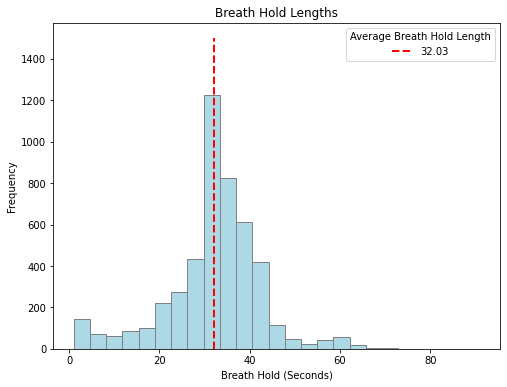

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
bh = np.array(under2['Data_breath_holds'], dtype = 'float32')
ax.hist(bh, bins = 25, color = 'lightblue', edgecolor = "grey")
ax.vlines(x = np.mean(under2['Data_breath_holds']), ymin = 0, ymax = 1500, linestyle='dashed', color = "red", linewidth = 2, label=f"{np.mean(under2['Data_breath_holds']):.2f}")
ax.legend(title = 'Average Breath Hold Length', loc = 'best')
ax.set_title('Breath Hold Lengths')
ax.set_xlabel('Breath Hold (Seconds)')
ax.set_ylabel('Frequency')

plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Building Model

In [17]:
df = under2

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['Data_breath_holds'], test_size=0.20)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

### What does the data look like before being scaled?

In [21]:
print(x_train[0:2])
print(x_train.shape)

5630    [0.5617, 0.5533, 0.5449, 0.5364, 0.528, 0.5196...
4244    [0.1387, 0.1481, 0.1576, 0.1673, 0.177, 0.1868...
Name: Trace, dtype: object
(1839,)


In [22]:
print(y_train[0:2])
print(y_train.shape)

5630    36.28
4244    33.79
Name: Data_breath_holds, dtype: float64
(1839,)


In [23]:
print(x_test[0:2])
print(x_test.shape)

5186    [0.048, 0.0561, 0.0644, 0.0727, 0.081, 0.0893,...
5427    [1.0624, 1.0673, 1.0721, 1.0767, 1.0813, 1.085...
Name: Trace, dtype: object
(959,)


In [24]:
print(y_test[0:2])
print(y_test.shape)

5186    27.38
5427    26.98
Name: Data_breath_holds, dtype: float64
(959,)


## Scale Data

In [25]:
# Change type of each row from np.array to list to put into scaler
x_train = np.array([list(row) for row in x_train])
x_val = np.array([list(row) for row in x_val])
x_test = np.array([list(row) for row in x_test])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [26]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### What does the data look like after being scaled?

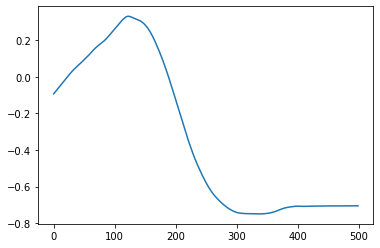

In [28]:
plt.plot(x_train[1020])

## Initialize Data for Model

In [30]:
#dataset
from torch.utils.data import Dataset

In [31]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [32]:
dataset = timeseries(x_train,y_train)
valid_dataset = timeseries(x_val,y_val)
test_dataset = timeseries(x_test,y_test)

In [33]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=100)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=100)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=100)

## Define LSTM Model (One Step Prediction)

In [68]:
#neural network
from torch import nn

class LSTM_Model(nn.Module):
    def __init__(self):
        super(LSTM_Model,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=1000,num_layers=2,batch_first=True) # change hidden size
        self.linear = nn.Linear(in_features=1000,out_features=1)
        
        
    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        #output = self.linear(torch.relu(output))
        output = self.linear(output)
        return output

model = LSTM_Model()

In [69]:
[p.size() for p in model.parameters()]

[torch.Size([4000, 1]),
 torch.Size([4000, 1000]),
 torch.Size([4000]),
 torch.Size([4000]),
 torch.Size([4000, 1000]),
 torch.Size([4000, 1000]),
 torch.Size([4000]),
 torch.Size([4000]),
 torch.Size([1, 1000]),
 torch.Size([1])]

In [43]:
# Declaring Criterion and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 50

## Training Loop

In [45]:
history = []
for i in range(epochs):
    
    train_mse = 0.0
    train_mae = 0.0
    train_loss = 0.0
    train_preds = []
    for x, y in train_loader:
        
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        ypred = model(x.view(-1,500,1))       
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1))      
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        # Calculate L1 Loss
        train_loss += loss.item()
        # Calculate MAE
        ypred = ypred.detach().numpy()
        train_mae += mean_absolute_error(ypred, y.view(-1,1))
        # Calculate MSE
        train_mse += mean_squared_error(ypred, y.view(-1,1))
        # R^2
        
        train_preds.append(ypred)
        
    valid_mse = 0.0
    valid_mae = 0.0
    valid_loss = 0.0
    val_preds = []
    for x, y in val_loader:
        # Forward Pass
        ypred = model(x.view(-1,500,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1))
        # Calculate L1 Loss
        valid_loss += loss.item()
        # Calculate MAE
        ypred = ypred.detach().numpy()
        valid_mae += mean_absolute_error(ypred, y.view(-1,1))
        # Calculate MSE
        valid_mse += mean_squared_error(ypred, y.view(-1,1))
        
        val_preds.append(ypred)

    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    if i%2 == 0:
        torch.save(model, 'lstm_single_output')
        print(f'Epoch {i+1} \t Training Loss: {train_loss/len(train_loader)} \tValidation Loss: {valid_loss/len(val_loader)}')
        print(f'\t\t Training MAE: {train_mae/len(train_loader)} \tValidation MAE: {valid_mae/len(val_loader)}')
        print(f'\t\t Training MSE: {train_mse/len(train_loader)} \tValidation MSE: {valid_mse/len(val_loader)}')
        print()
    
    

Epoch 1 	 Training Loss: 112.77860902485095 	Validation Loss: 112.78081665039062
		 Training MAE: 7.360926025792172 	Validation MAE: 7.339144134521485
		 Training MSE: 112.7786078202097 	Validation MSE: 112.78081512451172

Epoch 3 	 Training Loss: 112.35713838276111 	Validation Loss: 112.6521209716797
		 Training MAE: 7.329369871239913 	Validation MAE: 7.342922210693359
		 Training MSE: 112.35713958740234 	Validation MSE: 112.6521224975586

Epoch 5 	 Training Loss: 112.29040848581414 	Validation Loss: 112.82384796142578
		 Training MAE: 7.317413028917815 	Validation MAE: 7.338083362579345
		 Training MSE: 112.2904072811729 	Validation MSE: 112.8238525390625

Epoch 7 	 Training Loss: 111.83941971628289 	Validation Loss: 112.46353454589844
		 Training MAE: 7.316948514235647 	Validation MAE: 7.342206859588623
		 Training MSE: 111.83941610235917 	Validation MSE: 112.46353302001953



KeyboardInterrupt: 

In [44]:
h = history

In [47]:
h2 = [y for x in [h, history] for y in x]

In [51]:
h2

[(222.42652893066406, 114.22864227294922),
 (114.70292784038342, 120.30552215576172),
 (115.52554923609684, 113.11756134033203),
 (114.08195656224301, 112.50411682128906),
 (112.95482233950966, 112.76242218017578),
 (113.47743024324116, 112.89265594482421),
 (115.02431648655941, 112.55004272460937),
 (112.77735298558285, 112.87644653320312),
 (112.6627695184005, 112.72396545410156),
 (112.64104461669922, 112.64267425537109),
 (114.2179906744706, 112.92857513427734),
 (113.14422607421875, 112.8499038696289),
 (113.4272232055664, 112.70503234863281),
 (112.62801080001027, 112.92722625732422),
 (112.77860902485095, 112.78081665039062),
 (111.41733209710372, 112.91500091552734),
 (112.35713838276111, 112.6521209716797),
 (112.36781070106908, 112.80146942138671),
 (112.29040848581414, 112.82384796142578),
 (112.89618863557514, 112.73480529785157),
 (111.83941971628289, 112.46353454589844)]

## Plot Loss

In [52]:
history = torch.tensor(h2)

In [53]:
torch.save(model, 'lstm_bh_epochs')

In [54]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, '--', label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"{file}.pdf")

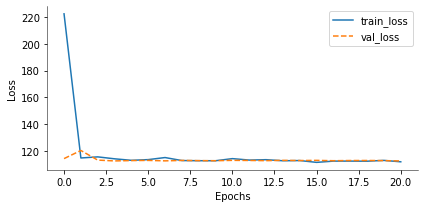

In [55]:
plot_loss(history, maxy = 50)

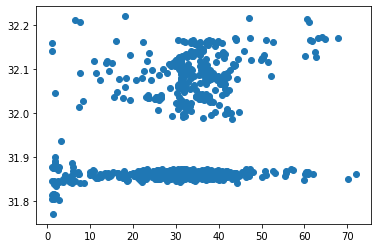

In [57]:
#test set actual vs predicted
test_set = timeseries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,500,1)).view(-1)
plt.scatter(test_set[:][1].view(-1), test_pred.detach().numpy(),label='predicted')
plt.show()

In [59]:
test_pred = model(test_set[:][0].view(-1,500,1)).view(-1)

In [60]:
np.mean(np.array(test_set[:][1].view(-1)))

31.545277

In [61]:
test_pred

tensor([31.8587, 31.8540, 31.8600, 31.8669, 31.8633, 32.1215, 32.1609, 31.8516,
        31.8608, 32.1011, 32.0839, 32.0039, 32.0255, 31.8546, 31.8598, 31.8702,
        31.8559, 32.1007, 32.0783, 32.0185, 32.1660, 31.8602, 32.1103, 31.8566,
        31.8637, 32.1361, 32.0846, 32.0978, 31.8621, 32.0922, 32.1609, 31.8579,
        32.0350, 31.8635, 32.0947, 31.8560, 31.8610, 32.1341, 31.8621, 31.8585,
        31.8586, 31.8689, 31.8588, 32.0986, 31.8668, 32.1097, 32.0589, 32.1127,
        31.8592, 32.0520, 31.8551, 31.8615, 32.1255, 31.8636, 32.0794, 31.8874,
        32.0178, 31.8658, 31.8620, 32.0681, 31.8689, 31.8575, 31.8606, 31.8464,
        31.8602, 31.8576, 31.8623, 32.1272, 31.8534, 32.1392, 32.0386, 31.8483,
        31.8691, 31.8581, 31.8493, 31.8628, 31.8563, 32.1586, 31.8594, 31.8711,
        32.1199, 32.0680, 31.8651, 31.8608, 31.8577, 31.9869, 31.8626, 31.8562,
        32.1713, 31.8655, 32.0369, 31.8566, 31.8553, 31.8544, 32.1591, 31.8729,
        31.8667, 31.8539, 31.8644, 31.86